In [310]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score

In [4]:
# read in the data
lyrics_data = pd.read_csv('data/lyrics.csv')
lyrics_data.drop(columns=['Unnamed: 0'], inplace= True)

In [ ]:
# write a function to clean the lyrics column to remove puncutation, line breaks, switch to lowercase etc

def clean_lyrics(lyric_str):
    lyric = re.sub('^\s+|\W+|[0-9]|\s+$', ' ', lyric_str)
    lyric = lyric.lower()
    return lyric

In [328]:
# apply the function
lyrics_data['lyrics'] = lyrics_data['lyrics'].apply(clean_lyrics)

In [329]:
# set up a function to split the data by year and pass it through the vectorizer
def split_and_vectorize(year, stop_words):
    lyrics_df = lyrics_data[lyrics_data['year'] == year]
    vectorizer = TfidfVectorizer(stop_words= stop_words, min_df=2)
    tfidf_mat = vectorizer.fit_transform(lyrics_df['lyrics'])
    words = vectorizer.get_feature_names_out()

    return lyrics_df, tfidf_mat, words

In [291]:
def svd_transform(tfidf_mat):
    lsa = make_pipeline(TruncatedSVD(n_components= 100), Normalizer(copy=False))
    lsa.fit(tfidf_mat.toarray())
    cusum_var = np.cumsum(lsa[0].explained_variance_ratio_)
    n_components = np.argmax(cusum_var >= 0.8)

    lsa = make_pipeline(TruncatedSVD(n_components= n_components), Normalizer(copy=False))
    tfidf_svd= lsa[0].fit_transform(tfidf_mat.toarray())
    svd = lsa[0]

    return svd, tfidf_svd
    

In [210]:
# fuction to find and print the most frequent term, just for curiousity
def print_most_frequent_terms(lyrics_df, stop_words):
    count_vectorizer = CountVectorizer(stop_words= stop_words)
    count_mat = count_vectorizer.fit_transform(lyrics_df['lyrics'])
    words = count_vectorizer.get_feature_names_out()
    total = count_mat.toarray().sum(axis = 0)
    sorted_ind = np.argsort(total)[::-1]

    sorted_words = words[sorted_ind]
    sorted_total = total[sorted_ind]

    for i in range(10):
        print(sorted_words[i], sorted_total[i])

In [348]:
def elbow_plot(tfidf_mat, year):
    k_vals = range(1,11)
    wcss = []

    for k in k_vals:
        kmeans_model = KMeans(n_clusters= k, n_init= 5, random_state= 12)
        kmeans_model.fit(tfidf_mat)
        wcss.append(kmeans_model.inertia_)

    plt.plot(k_vals, wcss)
    plt.savefig(f'fig/elbow_{year}.png', bbox_inches = 'tight')

In [311]:
def get_top_keywords_and_score(k, tfidf_svd, svd, words, n_terms):
    kmeans_model = KMeans(n_clusters=k, n_init= 4, random_state=12)
    labels = kmeans_model.fit_predict(tfidf_svd)
    original_clusters = svd.inverse_transform(kmeans_model.cluster_centers_)
    ordered_clusters = original_clusters.argsort()[:,::-1]
    score = silhouette_score(tfidf_svd, labels)
    print("Sihouette score:", score)
    for i in range(k):
        print(f"Cluster {i}:", end="")
        for idx in ordered_clusters[i,:n_terms]:
            print(f'{words[idx]}', end=" ")
        print()
        

In [380]:
# master list of stop words
stop_words = list(text.ENGLISH_STOP_WORDS.union(["oh", "yeah", "got", "let", "just", "hey", 
                                                 "don", "ll", "ve", "cause", "gonna", "uh", "ah",
                                                 "like", "eh", "whoa", "na", "really", "make", "know",
                                                 "ain", "laa", "la", "ooh"]))

def find_k_and_plot(year, stop_words):
    lyrics_df, tfidf_mat, words = split_and_vectorize(year, stop_words)
    print_most_frequent_terms(lyrics_df, stop_words)
    svd, tfidf_svd = svd_transform(tfidf_mat)
    elbow_plot(tfidf_svd, year)

    return tfidf_svd, svd, words


### 2010

love 451
baby 322
want 273
say 261
low 240
tonight 185
right 180
head 177
girl 159
bad 157


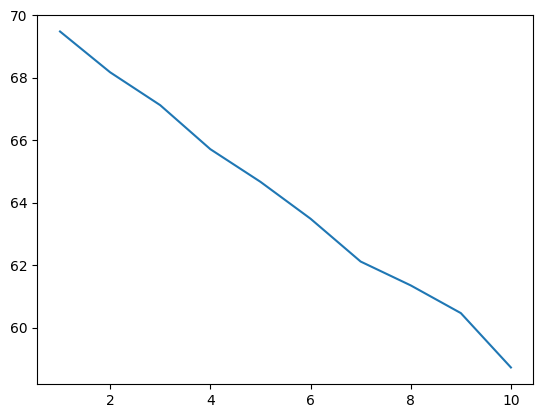

In [381]:
tfidf_svd, svd, words = find_k_and_plot(2010, stop_words)

In [383]:
get_top_keywords_and_score(7, tfidf_svd, svd, words, 10)

Sihouette score: 0.011992954560868218
Cluster 0:tonight baby want love boy way come night magic bring 
Cluster 1:love break want heart low gone tell gotta somebody falling 
Cluster 2:daddy soul dream way believing home maybe wanna tonight thought 
Cluster 3:head going song ay right stuck smile ropes shawty chorus 
Cluster 4:life win time thinkin honey better long em sky laughing 
Cluster 5:say baby gon girl need nothin way stuck tell hard 
Cluster 6:chick bad wish sexy ha damn girl answer use right 


### 2011

boom 334
baby 314
tonight 278
come 245
wanna 218
love 216
girl 194
way 170
want 162
bass 151


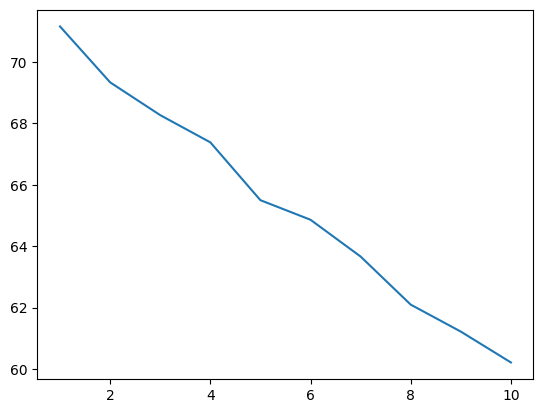

In [384]:
tfidf_svd, svd, words = find_k_and_plot(2011, stop_words)

In [385]:
get_top_keywords_and_score(8, tfidf_svd, svd, words, 10)

Sihouette score: 0.013570349632178895
Cluster 0:gon hands roll air goes ya ayo push saying light 
Cluster 1:tonight want edge wanna floor lovin alright waiting baby heart 
Cluster 2:baby feel wanna girl lover want world push stay ha 
Cluster 3:come change won home day way coming lost away message 
Cluster 4:money ma fuck drink niggas girls shit bottoms night bitch 
Cluster 5:chorus time boom crazy baby woah thinking love road life 
Cluster 6:girl rock pretty beautiful says shake fly work look hate 
Cluster 7:love place yellow black lot couldn instead hurts beg corner 


### 2012

baby 506
ooh 412
love 379
know 323
girl 211
good 202
whistle 201
want 181
come 171
make 157


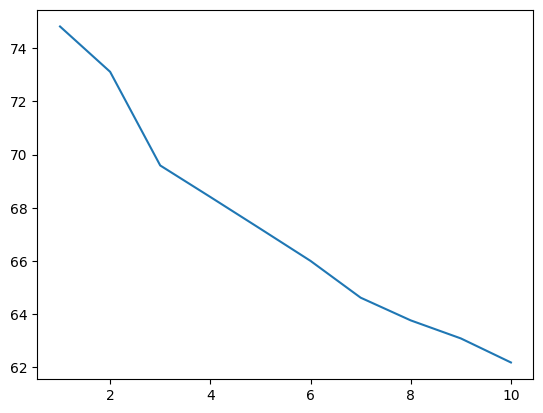

In [368]:
tfidf_svd, svd, words = find_k_and_plot(2012, stop_words)

In [370]:
get_top_keywords_and_score(7, tfidf_svd, svd, words, 10)

Sihouette score: 0.021348796635765357
Cluster 0:good little girl feeling time cup mmm hotter ride thing 
Cluster 1:woah think turn la love nights woo music ooh knew 
Cluster 2:wild smoke fun ooh ones care weed roll living drunk 
Cluster 3:home close run ass lights em going say right love 
Cluster 4:ooh baby la want para make happen talkin know ha 
Cluster 5:know away come baby turn make girl want heart wanna 
Cluster 6:love long place looking girl song baby babe life hard 


### 2013

love 446
know 288
ooh 233
night 231
wanna 184
baby 179
make 171
want 150
woah 133
feel 123


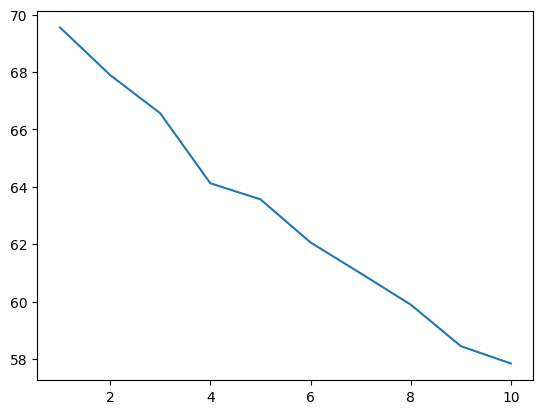

In [355]:
tfidf_svd, svd, words = find_k_and_plot(2013, stop_words)

In [371]:
get_top_keywords_and_score(9, tfidf_svd, svd, words, 10)

Sihouette score: 0.02069491883119416
Cluster 0:happen tonight bright talkin make shine diamond away life come 
Cluster 1:turn come woah baby ha wanna hear little make know 
Cluster 2:hands ass hoo everybody party lights woo talks cup shake 
Cluster 3:ooh baby la want babe wild night come para heard 
Cluster 4:day nigga bitch ho rack ice em think wide shit 
Cluster 5:chorus burn away wake fall won rain set heart break 
Cluster 6:away swear love drive looking knew woah giving throw won 
Cluster 7:good girl la feeling work time want thing body matter 
Cluster 8:love know baby say close lie way feels cake song 


### 2014

love 304
baby 227
burn 210
want 175
wanna 155
girl 150
tell 148
whoo 139
life 135
say 134


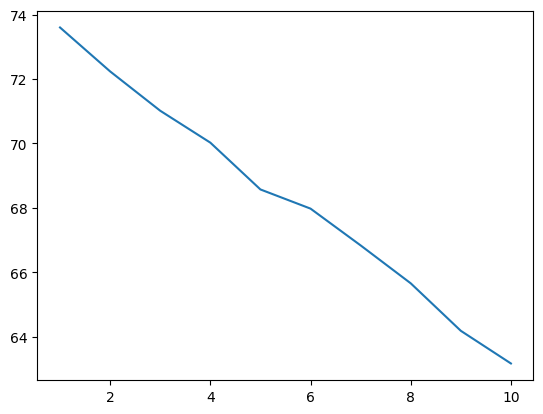

In [395]:
tfidf_svd, svd, words = find_k_and_plot(2014, stop_words)

In [400]:
get_top_keywords_and_score(10, tfidf_svd, svd, words, 10)

Sihouette score: 0.01432779312563468
Cluster 0:em tell wrong everybody real man ya talk dirty feel 
Cluster 1:nigga sky love summer believe world bass feet hide play 
Cluster 2:baby love life whoo little girl gotta say hold good 
Cluster 3:burn watch rolling lessons stars dreaming dollars sand tan cold 
Cluster 4:stay night map darling high clear chorus leave forget gotta 
Cluster 5:da hear song turning block shower louder wrote speak mean 
Cluster 6:clap happy little shake feel bring butt woah woo bow 
Cluster 7:woah goin round forget shots remember tonight chorus won dance 
Cluster 8:want bad bang look body shake bitches cool new kids 
Cluster 9:wanna babe burnin come place knows send told kind didn 


### 2015

love 538
doh 300
baby 253
need 194
wanna 192
tell 180
want 147
du 140
right 124
time 124


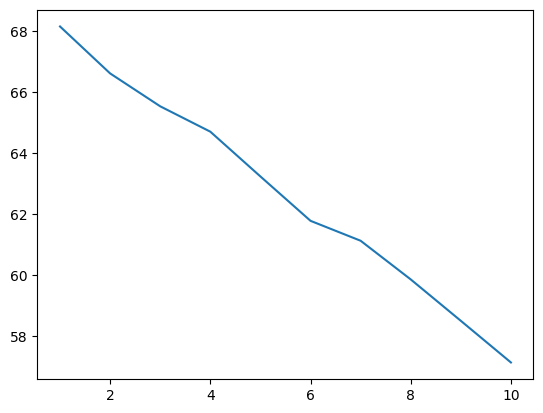

In [390]:
tfidf_svd, svd, words = find_k_and_plot(2015, stop_words)

In [389]:
get_top_keywords_and_score(10, tfidf_svd, svd, words, 10)

Sihouette score: 0.011570857631941983
Cluster 0:tell everybody em want summer man huh girl body talk 
Cluster 1:nigga roll love say bang come giving place ya feet 
Cluster 2:love baby need hold feel til won gotta felt life 
Cluster 3:burn watch lessons stars dreaming dollars losing money things lie 
Cluster 4:woah forget goin night round remember chorus shots map tonight 
Cluster 5:lie hide hear new inside want deny break alive louder 
Cluster 6:clap happy big bring wish day little woo feel cake 
Cluster 7:whoo storm perfect play sky heart little ready falling dark 
Cluster 8:real crying butt quick block look mean somethin night rolling 
Cluster 9:wanna baby classic kind girl send wrong shake babe song 


### 2016

love 403
baby 258
need 224
wanna 209
ha 194
work 193
time 175
say 174
git 165
want 156


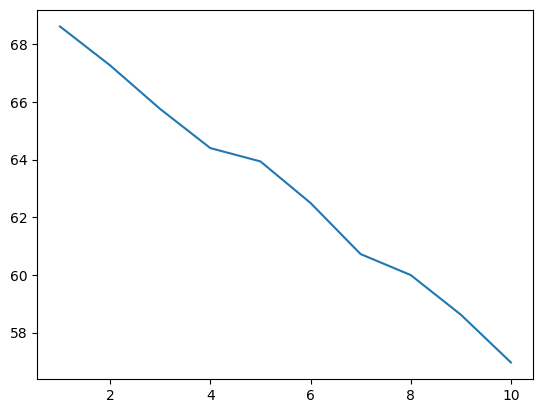

In [403]:
tfidf_svd, svd, words = find_k_and_plot(2016, stop_words)

In [407]:
get_top_keywords_and_score(10, tfidf_svd, svd, words, 10)

Sihouette score: 0.03459583916274022
Cluster 0:old years sick young love movie song case soon told 
Cluster 1:lose love run mmm time hold baby granted feel face 
Cluster 2:need nah dance feelin long love sign number ya stop 
Cluster 3:baby little hold close perfect watchin flex feel time moves 
Cluster 4:work watch ring ballin shot hold white woo money dead 
Cluster 5:mean said mind trying hands love phone summer wanna night 
Cluster 6:away boys lost hide mon good superman save understand run 
Cluster 7:wanna say love tell ha somethin better girl want baby 
Cluster 8:ahh say da swear suit warm mind tie tried wish 
Cluster 9:til die high low life day shoot getting happy starvin 


### 2017

low 455
baby 263
love 260
look 192
want 187
ha 166
bitch 162
fuck 153
say 142
ayy 141


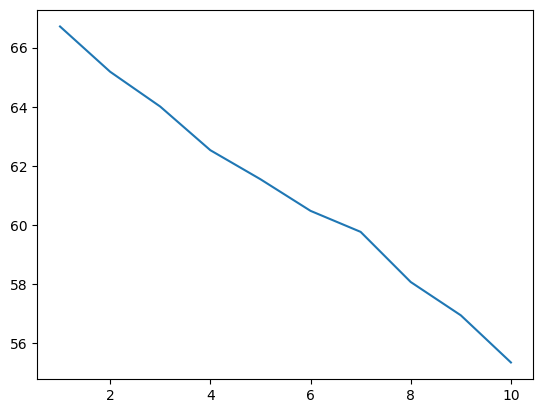

In [409]:
tfidf_svd, svd, words = find_k_and_plot(2017, stop_words)

In [411]:
get_top_keywords_and_score(8, tfidf_svd, svd, words, 10)

Sihouette score: 0.02935594313840579
Cluster 0:chase feels afraid gang catch big molly woah fuck scared 
Cluster 1:thunder alright pain long drivin heart hit away bullets holdin 
Cluster 2:ayy rollie heart look fuck east drunk que atlanta huh 
Cluster 3:fuck bitch bag ha niggas hold drop nigga ayy real 
Cluster 4:love baby come way time need body loyalty want low 
Cluster 5:da ready dumb young disaster plans answers trust happy broken 
Cluster 6:say love better won look stay want lucky wanna feel 
Cluster 7:account god bank nights ready slide pipe gun buy boy 


### 2018

love 291
baby 205
ayy 185
walk 181
dura 168
want 150
say 149
te 144
talk 136
fuck 128


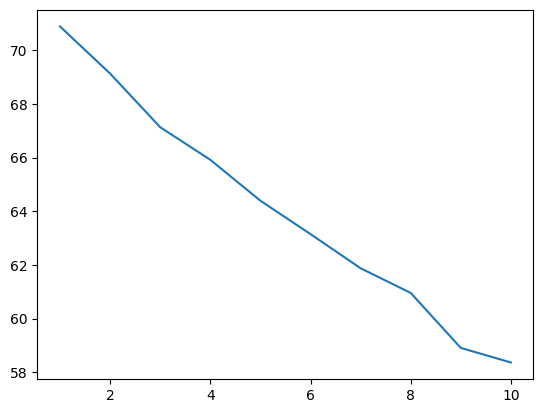

In [413]:
tfidf_svd, svd, words = find_k_and_plot(2018, stop_words)

In [414]:
get_top_keywords_and_score(9, tfidf_svd, svd, words, 10)

Sihouette score: 0.05443673602103724
Cluster 0:love wanna tell thunder come bad away baby believe chorus 
Cluster 1:isn help looking maybe blood giving say somebody walls feel 
Cluster 2:te que el mi pa yo en como lo se 
Cluster 3:taste da ya walk tequila boo need say ba want 
Cluster 4:goin long baby stay gotta said sorry better want middle 
Cluster 5:way girl takes feel good heaven sad need love stand 
Cluster 6:ayy fuck nigga bitch money man shit woo niggas bank 
Cluster 7:heart chorus break meant end head mercy gotta away ride 
Cluster 8:wishin lovers tryna ay say love things baby grown yuh 


### 2019

baby 254
love 232
want 216
say 213
bitch 188
need 184
shit 173
away 171
nigga 165
doo 162


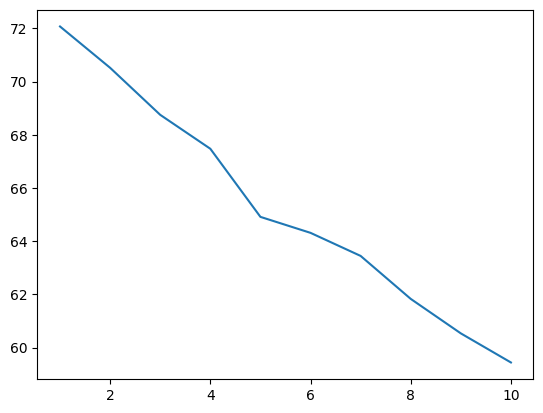

In [415]:
tfidf_svd, svd, words = find_k_and_plot(2019, stop_words)

In [417]:
get_top_keywords_and_score(10, tfidf_svd, svd, words, 10)

Sihouette score: 0.041116841519396895
Cluster 0:baby ya lil high bust trippin tell love tequila taste 
Cluster 1:beautiful crazy eyes ma kinda matter great night help psycho 
Cluster 2:need want wanna worst billie needs chorus dark bodies eilish 
Cluster 3:say need baby girl tonight want round wanna gotta woo 
Cluster 4:que lo el yo te como pa ese said yeh 
Cluster 5:want girlfriend means thinking talk boyfriend live tell far write 
Cluster 6:bitch ayy nigga shit money ha ass niggas real fuck 
Cluster 7:gave heart look better lot break ma woulda love god 
Cluster 8:away run shark meet time knew love used running alright 
Cluster 9:wrong guy thing right type bad walk goin tonight home 


### 2020

love 517
doo 392
say 232
way 227
babe 215
yummy 192
bring 184
ayy 161
memories 161
time 140


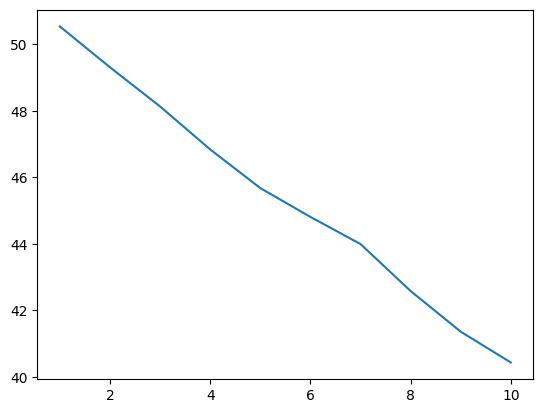

In [420]:
tfidf_svd, svd, words = find_k_and_plot(2020, stop_words)

In [ ]:
get_top_keywords_and_score(10, tfidf_svd, svd, words, 10)

Sihouette score: 0.015146509808005712
Cluster 0:light bring soul babe stars alight shining life night giving 
Cluster 1:said start better heart gone hope mind hate known time 
Cluster 2:heartless big paid heart wave young bitch nigga fault shit 
Cluster 3:party night thing mama girls wanna say good high daddy 
Cluster 4:dance foot slide say ayy want living room wanted life 
Cluster 5:nigga bitch pussy fuck hot turn shit feelin way huh 
Cluster 6:chasin going town used laying soon west lights whiskey holding 
Cluster 7:feeling ay okay best sunday brown good lil morning heaven 
Cluster 8:love girl stuck guy run wanna away babe hate baby 
Cluster 9:feel ya need felt loved doo baby mm want christmas 


### 2021

ody 172
baby 125
love 123
time 112
think 101
good 98
way 90
say 89
night 87
said 78


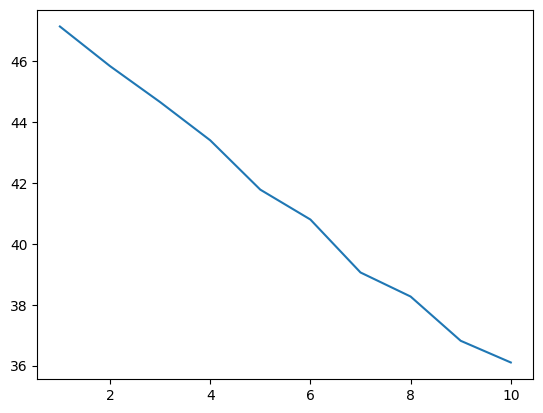

In [424]:
tfidf_svd, svd, words = find_k_and_plot(2021, stop_words)

In [425]:
get_top_keywords_and_score(9, tfidf_svd, svd, words, 10)

Sihouette score: 0.04298134571526891
Cluster 0:lil throat bitch bit real babies gon ayy come roll 
Cluster 1:good time night everybody come catch say baby tryna okay 
Cluster 2:mm hmm cup ha tell ya way gotta said love 
Cluster 3:woah body broke hurts heart chorus lil left happen big 
Cluster 4:mind mmm game switchin loving nothin love wouldn won good 
Cluster 5:christmas baby roll want right high bad left beat gon 
Cluster 6:lo te que yo en si tu mi el noche 
Cluster 7:trust love view things point breath forever babe maybe way 
Cluster 8:think man finally friend damn heat baby life bring ahead 


### 2022

woman 123
baby 104
time 84
quieres 76
que 72
want 69
need 63
said 57
te 56
yo 56


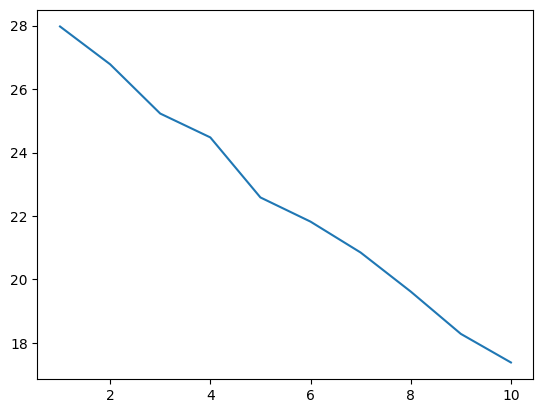

In [427]:
tfidf_svd, svd, words = find_k_and_plot(2022, stop_words)

In [428]:
get_top_keywords_and_score(9, tfidf_svd, svd, words, 10)

Sihouette score: 0.12413481814528193
Cluster 0:dog player man gon ass sitting dream said tell ma 
Cluster 1:nah need runnin proof child heat easy bitch freak fuck 
Cluster 2:said miss life crossed mm fingers want wrong giving love 
Cluster 3:woman bell coming okay time tonight class bad night alright 
Cluster 4:christmas jolly holly tree rockin want baby hear mistletoe hung 
Cluster 5:wanna baby dance want til close say eyes hand love 
Cluster 6:good makes god guess stuff maybe floor doin whiskey jack 
Cluster 7:bout right remember said maybe boots broke dancing keeping dreams 
Cluster 8:que esta te ey mi pero en yo est si 


### 2023

christmas 40
love 39
thing 36
baby 35
want 30
jingle 28
ding 25
won 22
time 21
bell 20


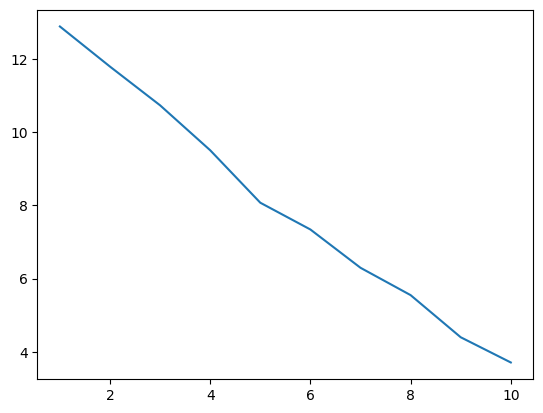

In [429]:
tfidf_svd, svd, words = find_k_and_plot(2023, stop_words)

In [430]:
get_top_keywords_and_score(9, tfidf_svd, svd, words, 10)

Sihouette score: 0.16915083295645542
Cluster 0:christmas holly jolly tree want hear baby singing mistletoe hung 
Cluster 1:lost love damn bitch said did right used say feeling 
Cluster 2:won love head summer drink gone blue tell young went 
Cluster 3:thing gotta woah sure baby love head hand comes lover 
Cluster 4:ayy shit fuck bitch nigga dick want pussy smack miss 
Cluster 5:good world leave damn doin write wanna didn girl wish 
Cluster 6:gave heart away year christmas day man lover baby face 
Cluster 7:bell time rock bells feet sleigh air away night right 
Cluster 8:need hard em cut feel used money gone town does 
